# Rotten Tomatoes Logistic Regression: Bag of Words Analysis
**Summary:** The Rotten Tomatoes Kaggle train dataset contains 156,060 records from 8,544 movie reviews. Each movie review was given a sentiment score from 0 (very negative) to 4 (very positive) by the Rotten Tomatoes reviewer. In addition, each review was split into parts of varying lengths and added to the dataset. For example, for a given movie review (*"This movie was really bad."*) there might be the following splits: *"This movie was really"*, *"This movie was"*, *"This movie"*, *"This"*. The splits were deduplicated, so each record in the dataset is unique. Finally, each of these splits was subsequently reviewed and given its own sentiment score via Mechanical Turk. 

In an interesting move, the creators of the dataset decided not to strip punctuation. The result is that there are a significant number of near duplicates within the dataset. In our *"This movie was really bad."* example we might have two splits, *"was really bad"* and *"was really bad."* Quite often the Mechanical Turk reviewers would assign different sentiment scores to each of these splits. As a result there is a significant amount of inherent noise in the data that cannot be modeled.

In addition, the Kaggle challenge is to predict the exact sentiment score for each record, not just whether the sentiment is positive (sentiment = 3-4), neutral (sentiment = 2) or negative (sentiment = 0-1).

While there are many ways to attack this problem the solution presented here uses a simple "bag of words" logistic regression model. In a bag of words model text strings are broken into individual words, and the words are analyzed independent of grammar or word order, though the model does track the count of each word within the string. We are using the standard scikit-learn vectorizer with tf-idf normalization to create a sparse matrix that we pass to the scikit-learn logistic regression classifier.


In [69]:
#general utility libraries
import re
import time
import random
import statistics as stat
import matplotlib.mlab as mlab
from pprint import pprint
import logging
from collections import Counter
from decimal import *
getcontext().prec = 4

# pandas
import pandas as pd

# numpy, matplotlib
import numpy as np
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
#from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

Get train & test csv files as a DataFrame

In [14]:
sentiment_train_df = pd.read_csv(filepath_or_buffer="train.tsv", sep='\t')
sentiment_test_df = pd.read_csv(filepath_or_buffer="test.tsv", sep='\t')

Below is a snippet of the training data.

In [15]:
sentiment_train_df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


Below is an example of functionally identical records with different sentiment scores.

In [16]:
sentiment_train_df.loc[sentiment_train_df.PhraseId.isin([208,209])]

,PhraseId,SentenceId,Phrase,Sentiment
207,208,7,is a plodding mess .,1
208,209,7,is a plodding mess,0


We ran some initial analysis on the data to determine the composition of the training set. As might be expected the set is heavily weighted to neutral sentiments.

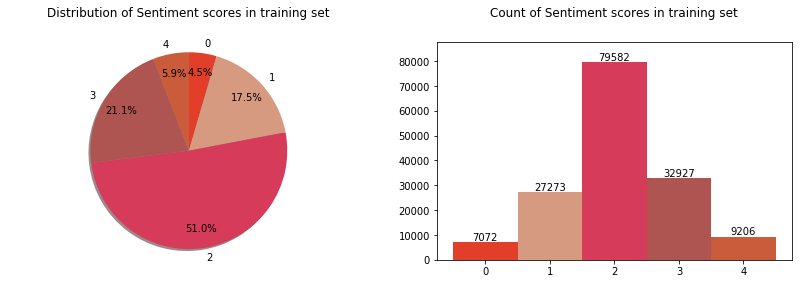

In [17]:
def autolabel_int(rects, ax):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height + 20,
                '%d' % int(height),
                ha='center', va='bottom')
        
def autolabel_percentage(rects, ax):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height + .02,
                '%.2f' % height,
                ha='center', va='bottom')

sizes = sentiment_train_df.groupby('Sentiment').size()

# Data to plot
labels = ['0','1','2','3','4']
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B"]

# Plot
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.pie(sizes, labels=labels, colors=colors, pctdistance=0.8,
        autopct='%1.1f%%', shadow=True, startangle=90, counterclock=False)
plt.title('Distribution of Sentiment scores in training set', y=1.1)
plt.axis('equal')

ax = plt.subplot(1, 2, 2)
y = sizes
N = len(y)
x = np.arange(1, N+1)
width = 1
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B"]
plt.title('Count of Sentiment scores in training set', y = 1.1)

rects = ax.bar(x, sizes, width, color=colors)
ax.set_xticks(x + width/2)
ax.set_xticklabels(labels)

autolabel_int(rects, ax)
plt.ylim(0, max(sizes)*1.1)

plt.show()

We split the data into 90% train data, 10% test data. We split by movie review ID (SentenceID) to ensure that all movie reviews and their fragments were either in the test or train data but not both.

In [48]:
def Create_Test_Train_Split(train_df, random_seed=42):
    random.seed(random_seed)
    split_size = 0.9

    total_sentences = max(train_df['SentenceId'])
    total_range = range(1,total_sentences + 1,1)
    test_split = int(total_sentences*split_size)
    test_list = random.sample(range(1,total_sentences+1),test_split)
    train_list = set(total_range).difference(set(test_list))

    train_data = train_df.loc[train_df.SentenceId.isin(test_list)]
    test_data = train_df.loc[train_df.SentenceId.isin(train_list)]

    print ('Training set   : {0} data points'.format(len(train_data)))
    print ('Test set       : {0} data points'.format(len(test_data)))
    
    return train_data, test_data

In [47]:
train_data, test_data = Create_Test_Train_Split(sentiment_train_df)

Training set   : 140143 data points
Test set       : 15917 data points



Create the splits for the train and test data

In [38]:
train_X = pd.Series(train_data['Phrase'])
train_Y = pd.Series(train_data['Sentiment'])

test_X = pd.Series(test_data['Phrase'])
test_Y = pd.Series(test_data['Sentiment'])

We built a pipeline to test parameters for the tf-idf vectorizer and the logistic regression algorithm simultaneously. As the number of tests increases combinatorially with the number of parameters tested we will limit the number of parameters evaluated.

In [24]:
tfidf_vect = TfidfVectorizer(binary=False, min_df=10, token_pattern=r'\b\w+\b',
                             sublinear_tf=True, use_idf=False)
logreg = LogisticRegression(max_iter=500, tol=1e-5, multi_class='multinomial', solver='newton-cg',
                            fit_intercept=True, class_weight=None)

pipeline = Pipeline([
    ('tfidf', tfidf_vect),
    ('clf', logreg),
])

parameters = {
    'tfidf__max_df': (0.5, 1.0),
    #'tfidf__min_df': (10, 15),
    'tfidf__ngram_range': ((1,1), (1,2)),  # unigrams and bigrams
    #'tfidf__sublinear_tf': (True, False),
    #'tfidf__use_idf': (True, False),
    #'tfidf__binary':(False, True),
    #'tfidf__use_idf': (True, False),
    #'tfidf__token_pattern': (u'(?u)\b\w\w+\b', r'\b\w+\b'),
    #'clf__penalty': ('l1', 'l2'),
    'clf__C': (0.8, 1.0, 1.5, 2.0, 2.5),
    #'clf__solver': ('newton-cg','lbfgs')
    #'clf__multi_class': ('ovr', 'multinomial'),
    #'clf__class_weight': ('balanced', None)
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)

    print("Performing grid search...")
    print()
    print("Pipeline:", [name for name, _ in pipeline.steps])
    print()
    print("Parameters:")
    pprint(parameters)
    t0 = time.time()
    grid_search.fit(train_X, train_Y)
    print("Done in {0:.1f}s".format(time.time() - t0))
    print()

    print("Best score: {0:.2f}%".format(grid_search.best_score_ * 100))
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

Performing grid search...

Pipeline: ['tfidf', 'clf']

Parameters:
{'clf__C': (0.1, 0.3, 0.5, 0.7, 0.8),
 'tfidf__max_df': (0.5, 0.75),
 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.4min finished


Done in 1068.5s

Best score: 0.594
Best parameters set:
	clf__C: 0.8
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)


GridSearchCV creates a summary dict of the parameter test results that can be imported into Pandas for review. 

In [68]:
grid_search_results_pd = pd.DataFrame(grid_search.cv_results_)
grid_search_results_pd.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__C,param_tfidf__max_df,param_tfidf__ngram_range,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,16.441049,0.467809,0.560606,0.581415,0.1,0.5,"(1, 1)","{'tfidf__ngram_range': (1, 1), 'tfidf__max_df'...",19,0.558861,...,0.563365,0.580600,0.557086,0.583642,0.562351,0.581389,0.595414,0.031524,0.002310,0.001292
1,26.707772,0.945015,0.561855,0.584961,0.1,0.5,"(1, 2)","{'tfidf__ngram_range': (1, 2), 'tfidf__max_df'...",17,0.561323,...,0.564899,0.583927,0.558049,0.586924,0.561209,0.584903,4.140647,0.041780,0.002375,0.001226
2,15.632754,0.444282,0.560606,0.581415,0.1,0.75,"(1, 1)","{'tfidf__ngram_range': (1, 1), 'tfidf__max_df'...",19,0.558861,...,0.563365,0.580600,0.557086,0.583642,0.562351,0.581389,0.396454,0.025855,0.002310,0.001292
3,26.454909,0.965670,0.561855,0.584961,0.1,0.75,"(1, 2)","{'tfidf__ngram_range': (1, 2), 'tfidf__max_df'...",17,0.561323,...,0.564899,0.583927,0.558049,0.586924,0.561209,0.584903,4.338634,0.054378,0.002375,0.001226
4,21.025532,0.454810,0.582377,0.626778,0.3,0.5,"(1, 1)","{'tfidf__ngram_range': (1, 1), 'tfidf__max_df'...",13,0.582120,...,0.583631,0.626526,0.579956,0.628935,0.582617,0.627850,0.745782,0.022905,0.001338,0.001472


We will take the best parameters from the pipeline testing and use them to train a model and predict sentiments from our test set.

In [46]:
for param_name in sorted(parameters.keys()):
    param = param_name.split('__')
    if param[0] == 'clf':
        setattr(logreg, param[1], best_parameters[param_name])
    elif param[0] == 'tfidf':
        setattr(tfidf_vect, param[1], best_parameters[param_name])

train_X_matrix = tfidf_vect.fit_transform(train_X)
logreg.fit(train_X_matrix, train_Y)

test_X_matrix = tfidf_vect.transform(test_X)
prediction = logreg.predict(test_X_matrix)
scores = logreg.score(test_X_matrix, test_Y)
print('Accuracy of model on test set is: {0:.2f}%'.format(scores * 100))

Accuracy of model on test set is: 61.07%


Here we see that the model's behavior was to over-predict the majority classifier (Sentiment=2) and under-predict the other sentiments.

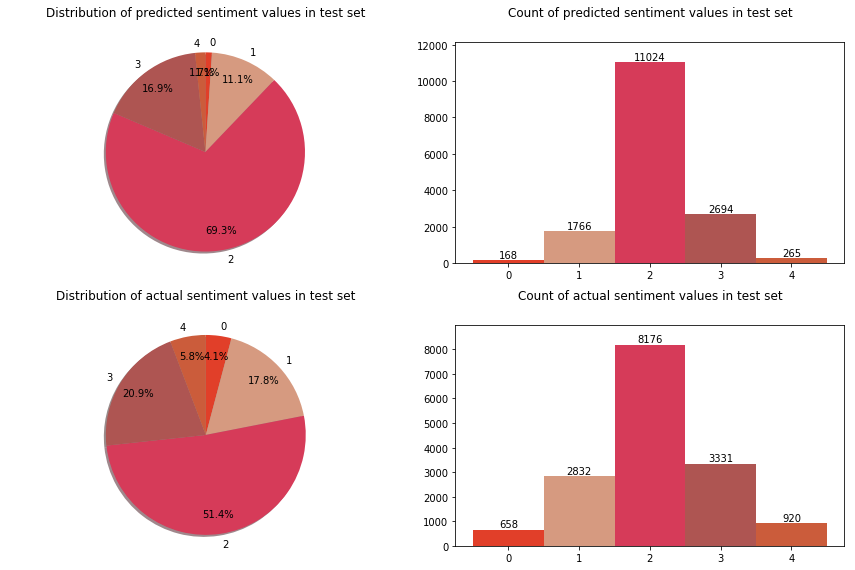

In [50]:
#build charts that show predicted distribution of sentiment scores in test data
model_prediction_df = pd.DataFrame(data=prediction, columns=['Sentiment'])
prediction_counts = model_prediction_df.groupby('Sentiment').size()

# Data to plot
labels = ['0','1','2','3','4']
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B"]

# Plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sizes = prediction_counts
plt.pie(sizes, labels=labels, colors=colors, pctdistance=0.8,
        autopct='%1.1f%%', shadow=True, startangle=90, counterclock=False)
plt.title('Distribution of predicted sentiment values in test set', y=1.1)
plt.axis('equal')

ax = plt.subplot(2, 2, 2)
y = sizes
N = len(y)
x = np.arange(1, N+1)
width = 1
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B"]
plt.title('Count of predicted sentiment values in test set', y = 1.1)

rects = ax.bar(x, sizes, width, color=colors)
ax.set_xticks(x + width/2)
ax.set_xticklabels(labels)

autolabel_int(rects, ax)
plt.ylim(0, max(sizes)*1.1)

#build charts that show actual distribution of sentiment scores in test data
actual_counts=test_data.groupby('Sentiment').size()

# Data to plot
labels = ['0','1','2','3','4']
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B"]

# Plot
#plt.figure(figsize=(14, 4))
plt.subplot(2, 2, 3)
sizes = actual_counts
plt.pie(sizes, labels=labels, colors=colors, pctdistance=0.8,
        autopct='%1.1f%%', shadow=True, startangle=90, counterclock=False)
plt.title('Distribution of actual sentiment values in test set', y=1.1)
plt.axis('equal')

ax = plt.subplot(2, 2, 4)
y = sizes
N = len(y)
x = np.arange(1, N+1)
width = 1
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B"]
plt.title('Count of actual sentiment values in test set', y = 1.1)

rects = ax.bar(x, sizes, width, color=colors)
ax.set_xticks(x + width/2)
ax.set_xticklabels(labels)

autolabel_int(rects, ax)
plt.ylim(0, max(sizes)*1.1)

plt.tight_layout()
plt.show()

The chart on the left lists the accuracy of the prediction for each sentiment score. It's easy to see the effect of the model over-predicting a neutral sentiment: The accuracy scores for strongly positive and strongly negative sentiments are low.

However, there is another way to look at the data. The model may not do a great job of predicting **exact** sentiment scores, but it does do a better of predicting **general** sentiment scores. For strong sentiments (*i.e.*, Sentiment = 0 or 4) where the model's prediction is incorrect, the model usually predicts the "adjacent" sentiment (*i.e.*, Sentiment = 1 or 3) instead of the neutral or opposite sentiment.

This effect is less pronounced for moderate sentiments (*i.e.*, Sentiment = 1 or 3) as the model usually predicts a neutral sentiment when the prediction is wrong. This seems likely due to two causes: (1) The majority of true sentiments are neutral, so the model is not significantly penalized for pursuing a majority class prediction strategy, and (2) Arbitrariness in the sentiments assigned to review fragments suggests that the boundaries between the sentiment classes are not strongly delineated. See immediately below for an example of arbitrary sentiment assignments. 

In [51]:
sentiment_train_df.loc[sentiment_train_df.PhraseId.isin([62568,62569])]

,PhraseId,SentenceId,Phrase,Sentiment
62567,62568,3164,Middle East struggle,2
62568,62569,3164,Middle East,1


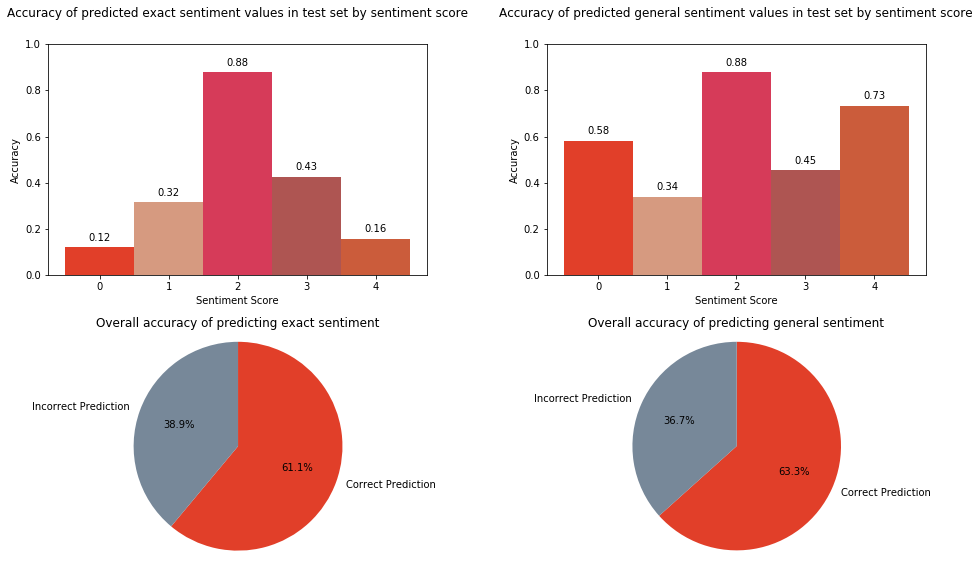

In [53]:
prediction_valid_df = pd.DataFrame(test_data['Sentiment'])
prediction_valid_df = prediction_valid_df.assign(Prediction=prediction)

#build chart to show exact accuracy for each sentiment score
ser1 = prediction_valid_df[(prediction_valid_df.Prediction == prediction_valid_df.Sentiment)] \
    .groupby('Sentiment').size()
ser2 = prediction_valid_df.groupby('Sentiment').size()
accuracies_exact = ser1/ser2

accuracies_general = []
for i in range(0,5):
    if (i==0) or (i==1):
        general_predictions = len(prediction_valid_df.loc[(prediction_valid_df.Sentiment == i) & \
                    (prediction_valid_df.Prediction.isin([0,1]))]) / \
                    len(prediction_valid_df.loc[(prediction_valid_df.Sentiment == i)])

    if (i==3) or (i==4):
        general_predictions = len(prediction_valid_df.loc[(prediction_valid_df.Sentiment == i) & \
                                     (prediction_valid_df.Prediction.isin([3,4]))]) / \
                                     len(prediction_valid_df.loc[(prediction_valid_df.Sentiment == i)])
            
    if i==2:
        general_predictions = accuracies_exact[2]
    accuracies_general.append(general_predictions)

# Data to plot
labels = ['0','1','2','3','4']
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B"]

plt.figure(figsize=(14, 8))
ax1 = plt.subplot(2,2,1)
y = accuracies_exact
N = len(y)
x = np.arange(1, N+1)
width = 1
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B"]
plt.title('Accuracy of predicted exact sentiment values in test set by sentiment score', y = 1.1)

rects1 = ax1.bar(x, accuracies_exact, width, color=colors)
ax1.set_xticks(x + width/2)
ax1.set_xticklabels(labels)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Sentiment Score')

autolabel_percentage(rects1, ax1)
plt.ylim(0, 1.0)
#plt.show()


ax2 = plt.subplot(2,2,2)
y = accuracies_general
N = len(y)
x = np.arange(1, N+1)
width = 1
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B"]
plt.title('Accuracy of predicted general sentiment values in test set by sentiment score', y = 1.1)

rects2 = ax2.bar(x, accuracies_general, width, color=colors)
ax2.set_xticks(x + width/2)
ax2.set_xticklabels(labels)
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Sentiment Score')

autolabel_percentage(rects2, ax2)
plt.ylim(0, 1.0)

accuracy_exact = [len(prediction_valid_df.loc[(prediction_valid_df.Sentiment == prediction_valid_df.Prediction)]) / \
                len(prediction_valid_df)]
accuracy_exact.append(1-accuracy_exact[0])
labels = ['Correct Prediction','Incorrect Prediction']
colors_exact = ["#E13F29",'lightslategray'] 
plt.subplot(2, 2, 3)
plt.pie(accuracy_exact, labels=labels, colors=colors_exact, explode=(0,0),
    autopct='%1.1f%%', shadow=False, startangle=90, counterclock=False)
title = "Overall accuracy of predicting exact sentiment" 
plt.title(title)
plt.axis('equal')


top = len(prediction_valid_df.loc[(prediction_valid_df.Sentiment.isin([0,1]) & \
                                   prediction_valid_df.Prediction.isin([0,1])) | 
                                  (prediction_valid_df.Sentiment.isin([3,4]) & \
                                   prediction_valid_df.Prediction.isin([3,4])) | 
                                  (prediction_valid_df.Sentiment.isin([2]) & \
                                   prediction_valid_df.Prediction.isin([2]))])

accuracy_general = [top / len(prediction_valid_df)]
accuracy_general.append(1-accuracy_exact[0])
labels = ['Correct Prediction','Incorrect Prediction']
colors_exact = ["#E13F29",'lightslategray'] 
plt.subplot(2, 2, 4)
plt.pie(accuracy_general, labels=labels, colors=colors_exact, explode=(0,0),
    autopct='%1.1f%%', shadow=False, startangle=90, counterclock=False)
title = "Overall accuracy of predicting general sentiment" 
plt.title(title)
plt.axis('equal')

plt.tight_layout()
plt.show()

Below are bar charts that show the distribution of predictions for each true sentiment in the test set.

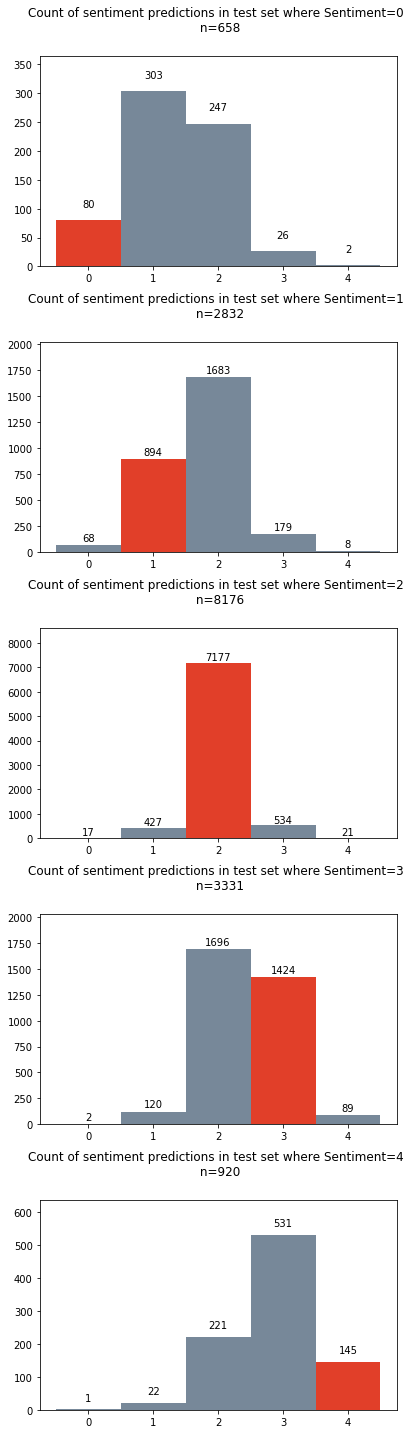

In [54]:
# Data to plot
labels = ['0','1','2','3','4']
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B"]
plt.figure(figsize=(6, 20))

sentiment_count = prediction_valid_df.groupby('Sentiment').size()

for i in range(0,5):
    prediction_counts = []
    prediction_counts = prediction_valid_df[prediction_valid_df.Sentiment==i].groupby('Prediction').size()

    colors = ['lightslategray','lightslategray', 'lightslategray', 'lightslategray', 'lightslategray']
    colors[i] = "#E13F29"
    ax = plt.subplot(5, 1, i+1)
    y = prediction_counts
    N = len(y)
    x = np.arange(1, N+1)
    width = 1
    titletxt = 'Count of sentiment predictions in test set where Sentiment=%d \n n=%d' % (i, sentiment_count[i])
    plt.title(titletxt, y = 1.1)

    rects = ax.bar(x, y, width, color=colors)
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(labels)

    autolabel_int(rects, ax)
    plt.ylim(0, max(y)*1.2)

plt.tight_layout()
plt.show()

**Some final notes...**
1. The logistic regression algorithm was fairly indifferent to the choice of parameters. Most reasonable models showed an accuracy of ~60% on initial testing. The 'best' model was only ~0.2% more accurate than its closest rival.
2. All parameter choices were far more sensitive to the choice of test/train split. Depending on how the data was split each model's accuracy might vary by ~±1%. Since this variation dwarfs the tested variation between models it is helpful to test each model a number of times to build an expected distribution of accuracies. From that one can compare the mean of each model's distribution to determine how likely any difference in means is due to chance.

To highlight this spread the histogram below shows a sample good model run against 100 different test/train splits. The results are bucketed into 20 bins. The mean of the distribution is shown as the black dashed vertical line. One standard deviation above and below the mean are shown as blue dashed vertical lines. The black dashed curved line is the line of best fit.

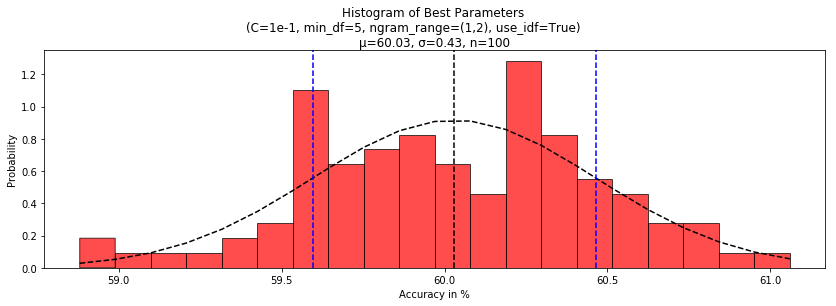

In [67]:
# '\u03BC' - mu
# '\u03C3' - sigma
# "#D63B59" - red

#100 random seeds, C=1e-1, min_df=5, ngram_range=(1,2), use_idf=True
measured_accuracies = [Decimal('0.5966'), Decimal('0.5994'), Decimal('0.6033'), Decimal('0.5933'), Decimal('0.6002'), 
                    Decimal('0.6024'), Decimal('0.6074'), Decimal('0.6055'), Decimal('0.6013'), Decimal('0.5998'), 
                    Decimal('0.5940'), Decimal('0.5969'), Decimal('0.6065'), Decimal('0.5991'), Decimal('0.6047'), 
                    Decimal('0.5955'), Decimal('0.5964'), Decimal('0.5962'), Decimal('0.5975'), Decimal('0.5888'), 
                    Decimal('0.5958'), Decimal('0.6040'), Decimal('0.6049'), Decimal('0.6032'), Decimal('0.5901'), 
                    Decimal('0.6029'), Decimal('0.6001'), Decimal('0.5974'), Decimal('0.5953'), Decimal('0.5968'), 
                    Decimal('0.5986'), Decimal('0.6021'), Decimal('0.6032'), Decimal('0.6022'), Decimal('0.6055'), 
                    Decimal('0.5956'), Decimal('0.6007'), Decimal('0.5983'), Decimal('0.6030'), Decimal('0.6074'), 
                    Decimal('0.6045'), Decimal('0.5915'), Decimal('0.5995'), Decimal('0.6050'), Decimal('0.6041'), 
                    Decimal('0.5983'), Decimal('0.6052'), Decimal('0.5960'), Decimal('0.6022'), Decimal('0.5991'), 
                    Decimal('0.5996'), Decimal('0.5978'), Decimal('0.5995'), Decimal('0.6057'), Decimal('0.5997'), 
                    Decimal('0.6007'), Decimal('0.6040'), Decimal('0.6073'), Decimal('0.5954'), Decimal('0.5991'), 
                    Decimal('0.6020'), Decimal('0.6085'), Decimal('0.5953'), Decimal('0.6020'), Decimal('0.6065'), 
                    Decimal('0.6008'), Decimal('0.6044'), Decimal('0.6022'), Decimal('0.6031'), Decimal('0.5998'), 
                    Decimal('0.5954'), Decimal('0.5979'), Decimal('0.6039'), Decimal('0.5895'), Decimal('0.5964'), 
                    Decimal('0.6027'), Decimal('0.6062'), Decimal('0.6028'), Decimal('0.6020'), Decimal('0.5984'), 
                    Decimal('0.5970'), Decimal('0.5991'), Decimal('0.5995'), Decimal('0.5963'), Decimal('0.5969'), 
                    Decimal('0.5964'), Decimal('0.5927'), Decimal('0.6024'), Decimal('0.5981'), Decimal('0.6040'), 
                    Decimal('0.5948'), Decimal('0.6016'), Decimal('0.6077'), Decimal('0.5961'), Decimal('0.6017'), 
                    Decimal('0.6106'), Decimal('0.6026'), Decimal('0.5983'), Decimal('0.6014'), Decimal('0.6024')]

mu = float(stat.mean(measured_accuracies) * Decimal(100))
sigma = float(stat.stdev(measured_accuracies) * Decimal(100))

plt.figure(figsize=(14, 4))
n, bins, patches = plt.hist(np.asarray(measured_accuracies, dtype='float')*100, bins=20, facecolor='red', 
                            edgecolor='black', linewidth=1, histtype='bar', alpha=0.7, normed=1)
plt.title("Histogram of Best Parameters \n(C=1e-1, min_df=5, ngram_range=(1,2), use_idf=True) \
          \n\u03BC=60.03, \u03C3=0.43, n=100")
plt.xlabel("Accuracy in %")
plt.ylabel("Probability")
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'k--')
plt.axvline(x=mu, linestyle='dashed', color='black', label='label')
plt.axvline(x=mu-sigma, linestyle='dashed', color='blue', label='label')
plt.axvline(x=mu+sigma, linestyle='dashed', color='blue', label='label')

plt.show()